In [1]:
#setup
data_dir='../../Data/Weather'
file_index= 'BSSSBSBB'#'BBBSBBBB' 
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     78.3| 32.5906| -86.2103|       SNWD|USC00018859|     1|[00 00 00 00 00 0...|1949.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       SNWD|USC00018859|     0|[00 00 00 00 00 0...|1950.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       SNWD|USC00018859|     0|[00 00 00 00 00 0...|1951.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       SNWD|USC00018859|     0|[00 00 00 00 00 0...|1952.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       SNWD|USC00018859|     0|[00 00 00 00 00 0...|1953.0|BSSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

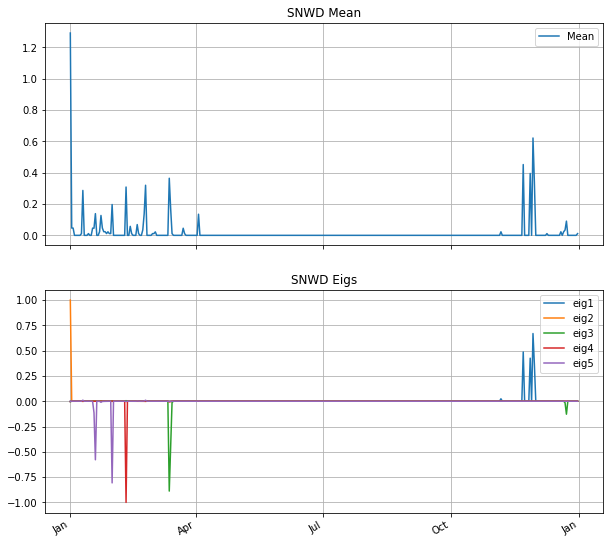

In [7]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,10));
k=5
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [8]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

In [9]:
len(v)

5

### plot the percent of residual variance on average

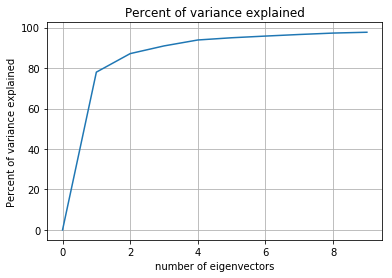

In [10]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [11]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [12]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 2266
after filter 91


In [13]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [14]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        #Title='c_1=%f, r_1=%f'%(row['coeff_1'],row['res_1'])
        #Title='c_2=%f, r_2=%f'%(row['coeff_2'],row['res_2'])
        Title='c_3=%f, r_3=%f'%(row['coeff_3'],row['res_3'])
        #Title='c_4=%f, r_4=%f'%(row['coeff_4'],row['res_4'])
        #Title='c_5=%f, r_5=%f'%(row['coeff_5'],row['res_5'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=1, figsize=(15,3)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    #fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    fig,axes=plt.subplots(row_n,column_n, sharey='row',figsize=figsize);
    k=0
    for i in range(column_n):
        row=rows[k]
        k+=1
        #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
        #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
        #print i,j,_title,axes[i,j]
        plot_decomp(row,Mean,v,fig=fig,ax=axes[i],interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [15]:
#df4=df3.filter(df3.res_1<0.4).sort(df3.coeff_1)
df4=df3.sort(df3.coeff_1)
rows=df4.take(4)
df4.select('coeff_1','res_1').show(4)

+-------------------+------------------+
|            coeff_1|             res_1|
+-------------------+------------------+
|-1.1760976539178916|0.9999890064334338|
|-1.0871514053517508|0.9999772049141354|
|-1.0871514053517508|0.9999772066174785|
|-1.0689419371413598|0.9999719170041637|
+-------------------+------------------+
only showing top 4 rows



/root/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


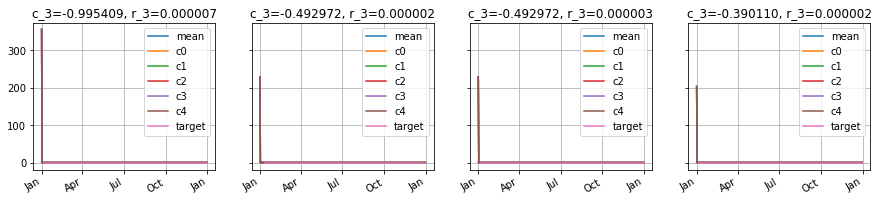

In [16]:
plot_recon_grid(rows)

In [17]:
df4=df3.sort(df3.coeff_1,ascending=False)
rows=df4.take(4)
df4.select('coeff_1','res_1').show(4)

+-------------------+-------------------+
|            coeff_1|              res_1|
+-------------------+-------------------+
| 2086.5185612056666|6.22123639050806E-8|
|-0.9276050366223645| 0.9996691325269625|
|-0.9278891145522361| 0.9996687827102133|
| -0.928169994682235| 0.9997471485345294|
+-------------------+-------------------+
only showing top 4 rows



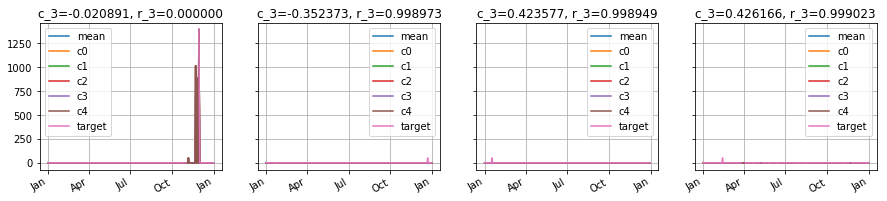

In [18]:
plot_recon_grid(rows)

In [19]:
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2)
rows=df5.take(4)
df5.select('coeff_2','res_2').show(4)

+------------------+-------------------+
|           coeff_2|              res_2|
+------------------+-------------------+
|0.1703092728362901|5.55499431353653E-8|
|23.712485047541108|7.07163301470727E-4|
|23.712485047541108|7.07163301470727E-4|
|23.712485047541108|7.07163301470727E-4|
+------------------+-------------------+
only showing top 4 rows



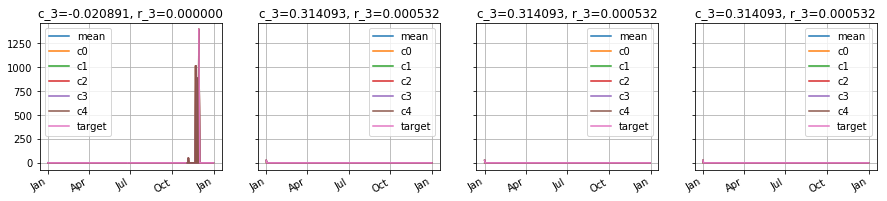

In [20]:
plot_recon_grid(rows)

In [21]:
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
rows=df5.take(4)
df5.select('coeff_2','res_2').show(4)

+------------------+--------------------+
|           coeff_2|               res_2|
+------------------+--------------------+
|354.70663436831603|1.448448088782645...|
|227.70887919085868|7.240470607538141E-6|
|227.70887919085868|6.964765723867618E-6|
|201.70933876082802|5.340761372125388E-6|
+------------------+--------------------+
only showing top 4 rows



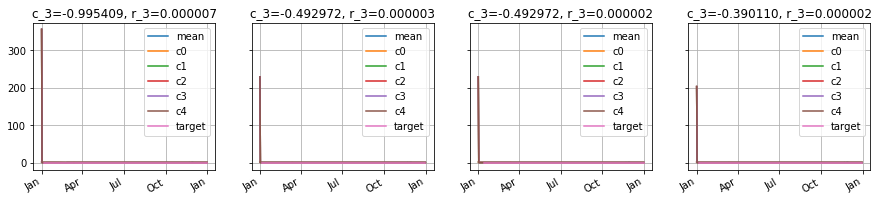

In [22]:
plot_recon_grid(rows)

In [23]:
df6=df3.filter(df3.res_3<0.4).sort(df3.coeff_3)
rows=df6.take(4)
df6.select('coeff_3','res_3').show(4)

+-------------------+-------------------+
|            coeff_3|              res_3|
+-------------------+-------------------+
|-359.96778924315475|0.01646349749984056|
|-179.87230506259544|0.05802134902934772|
|-150.85439871635367|0.30406832904853576|
|-124.05956411233004|0.07848807650869376|
+-------------------+-------------------+
only showing top 4 rows



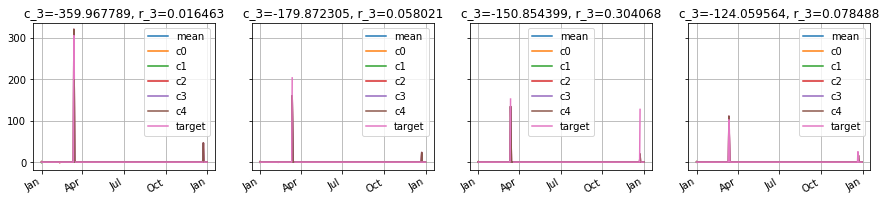

In [24]:
plot_recon_grid(rows)

In [25]:
df6=df3.filter(df3.res_3<0.4).sort(df3.coeff_3,ascending=False)
rows=df6.take(4)
df6.select('coeff_3','res_3').show(4)

+------------------+--------------------+
|           coeff_3|               res_3|
+------------------+--------------------+
|0.3140925384072928|5.321118484421799E-4|
|0.3140925384072928|5.321118484421799E-4|
|0.3140925384072928|5.321118484421799E-4|
|0.3140925384072928|5.321118484421799E-4|
+------------------+--------------------+
only showing top 4 rows



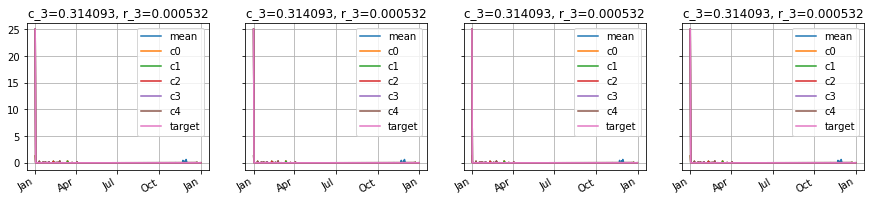

In [26]:
plot_recon_grid(rows)

In [27]:
df7=df3.filter(df3.res_4<0.4).sort(df3.coeff_4)
rows=df7.take(4)
df7.select('coeff_4','res_4').show(4)

+-------------------+--------------------+
|            coeff_4|               res_4|
+-------------------+--------------------+
|  -304.679680716867|1.476441038787549...|
|-253.68102853189177|8.732948485774989E-7|
|-50.686393364245255|6.457226259954838E-5|
|-24.687080485630442|3.979450017855667...|
+-------------------+--------------------+
only showing top 4 rows



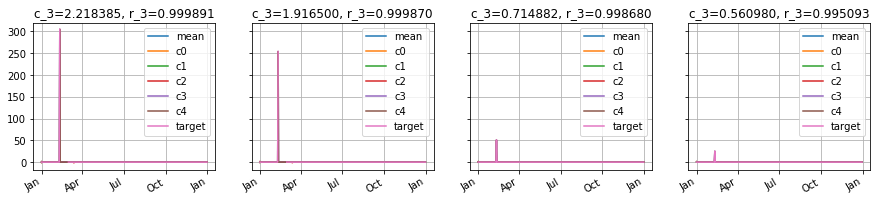

In [28]:
plot_recon_grid(rows)

In [29]:
df7=df3.filter(df3.res_4<0.4).sort(df3.coeff_4,ascending=False)
rows=df7.take(4)
df7.select('coeff_4','res_4').show(4)

+-------------------+------------------+
|            coeff_4|             res_4|
+-------------------+------------------+
|0.24781149123075155|4.2314525765815E-4|
|0.24781149123075155|4.2314525765815E-4|
|0.24781149123075155|4.2314525765815E-4|
|0.24781149123075155|4.2314525765815E-4|
+-------------------+------------------+
only showing top 4 rows



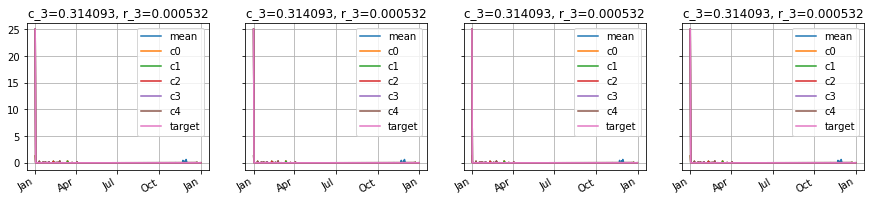

In [30]:
plot_recon_grid(rows)

In [31]:
df8=df3.filter(df3.res_5<0.4).sort(df3.coeff_5)
rows=df8.take(4)
df8.select('coeff_5','res_5').show(4)

+-------------------+--------------------+
|            coeff_5|               res_5|
+-------------------+--------------------+
|-131.92799831087746| 0.06982840099761474|
|-126.07433218972179|6.517649012518386E-4|
|-111.60673654235717| 0.03801218413579628|
|-105.08702589812921| 0.03975321060201081|
+-------------------+--------------------+
only showing top 4 rows



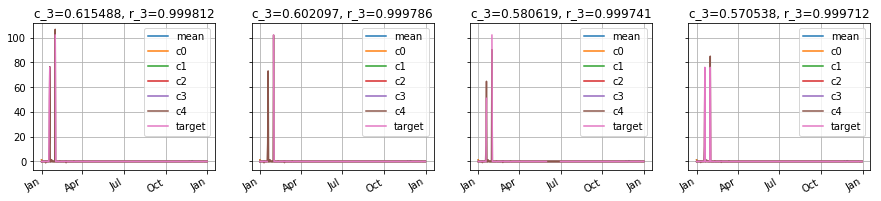

In [32]:
plot_recon_grid(rows)

In [33]:
df8=df3.filter(df3.res_5<0.4).sort(df3.coeff_5,ascending=False)
rows=df8.take(4)
df8.select('coeff_5','res_5').show(4)

+-------------------+--------------------+
|            coeff_5|               res_5|
+-------------------+--------------------+
|0.20328136101333766|3.498213501872714E-4|
|0.20328136101333766|3.498213501872714E-4|
|0.20328136101333766|3.498213501872714E-4|
|0.20328136101333766|3.498213501872714E-4|
+-------------------+--------------------+
only showing top 4 rows



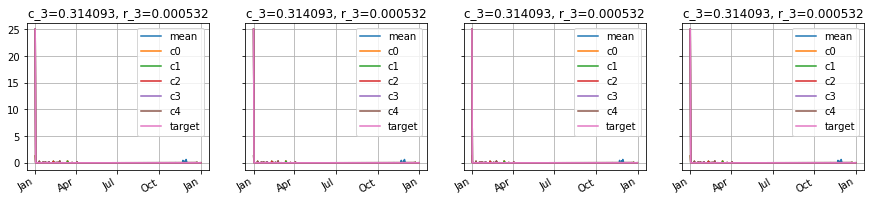

In [34]:
plot_recon_grid(rows)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.901715430304
residual normalized norm  after mean + top eigs: [  9.98417844e-01   7.07163301e-04   5.32111848e-04   4.23145258e-04
   3.49821350e-04]


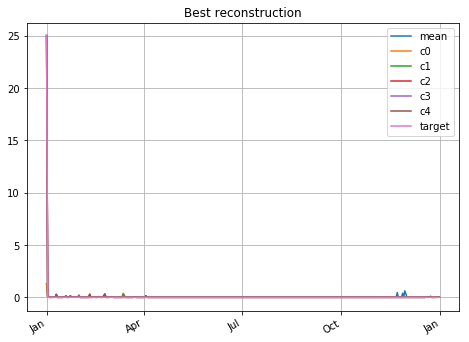

In [35]:
row=rows[2]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [37]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    
    plt.plot(vals,P)
    vals=[vals[0]]+vals
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

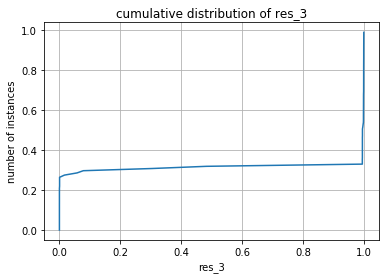

In [38]:
plot_CDF('res_3')

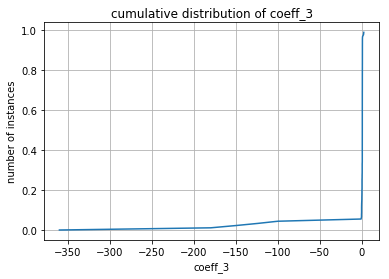

In [39]:
plot_CDF('coeff_3')

In [40]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [41]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
3.3M	../../Data/Weather/US_Weather_BSSSBSBB.parquet
1.7M	../../Data/Weather/decon_BBBSBBBB.parquet
3.0M	../../Data/Weather/decon_BBBSBBBB_PRCP.parquet
1.6M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
2.9M	../../Data/Weather/decon_BSSSBSBB_PRCP.parquet
564K	../../Data/Weather/decon_BSSSBSBB_SNWD.parquet
